In [1]:
import numpy as np
np.Inf = np.inf
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import time

class AdaptiveMultigridComplex:
    """
    自适应多重网格方法求解复数系统
    适用于求解复数系数的椭圆型偏微分方程
    """
    
    def __init__(self, n, max_levels=5, tolerance=1e-8, max_iterations=100):
        """
        初始化自适应多重网格求解器
        
        参数:
        n: 网格大小 (n x n)
        max_levels: 最大网格层数
        tolerance: 收敛容差
        max_iterations: 最大迭代次数
        """
        self.n = n
        self.max_levels = max_levels
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.convergence_history = []
        self.level_info = []
        
    def create_complex_matrix(self, n, alpha=1.0, beta=1.0j):
        """
        创建复数系数矩阵 (离散化的复数椭圆算子)
        -α∇²u - iβu = f
        """
        print(f"创建 {n}x{n} 复数系数矩阵...")
        print(f"  系数: α = {alpha}, β = {beta}")
        
        h = 1.0 / (n + 1)  # 网格间距
        
        # 主对角线: 4α/h² + iβ
        main_diag = (4 * alpha / h**2 + beta) * np.ones(n**2, dtype=complex)
        
        # 上下对角线: -α/h²
        off_diag_1 = (-alpha / h**2) * np.ones(n**2 - 1, dtype=complex)
        off_diag_n = (-alpha / h**2) * np.ones(n**2 - n, dtype=complex)
        
        # 处理边界条件 (移除跨行的连接)
        for i in range(n-1, n**2-1, n):
            off_diag_1[i] = 0
            
        A = diags([off_diag_n, off_diag_1, main_diag, off_diag_1, off_diag_n],
                 [-n, -1, 0, 1, n], format='csr')
        
        print(f"  矩阵创建完成: {A.shape}, 非零元素: {A.nnz}")
        return A
    
    def create_rhs(self, n, func_type='sine'):
        """创建右端项"""
        h = 1.0 / (n + 1)
        x = np.linspace(h, 1-h, n)
        y = np.linspace(h, 1-h, n)
        X, Y = np.meshgrid(x, y)
        
        if func_type == 'sine':
            # 复数正弦函数
            f = np.sin(2*np.pi*X) * np.sin(2*np.pi*Y) * (1 + 1j)
        elif func_type == 'exponential':
            # 复数指数函数
            f = np.exp(X + 1j*Y)
        else:
            # 默认函数
            f = np.ones((n, n), dtype=complex)
            
        return f.flatten()
    
    def restrict(self, u_fine):
        """限制算子：细网格到粗网格"""
        n_fine = int(np.sqrt(len(u_fine)))
        n_coarse = n_fine // 2
        
        if n_coarse < 2:
            return u_fine
            
        u_fine_2d = u_fine.reshape((n_fine, n_fine))
        u_coarse_2d = np.zeros((n_coarse, n_coarse), dtype=complex)
        
        # 全权重限制 (9点模板)
        for i in range(n_coarse):
            for j in range(n_coarse):
                ii, jj = 2*i+1, 2*j+1
                weight_sum = 0
                value_sum = 0
                
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = ii + di, jj + dj
                        if 0 <= ni < n_fine and 0 <= nj < n_fine:
                            if di == 0 and dj == 0:
                                weight = 4
                            elif di == 0 or dj == 0:
                                weight = 2
                            else:
                                weight = 1
                            weight_sum += weight
                            value_sum += weight * u_fine_2d[ni, nj]
                
                u_coarse_2d[i, j] = value_sum / weight_sum if weight_sum > 0 else 0
                
        return u_coarse_2d.flatten()
    
    def prolongate(self, u_coarse, n_fine):
        """延拓算子：粗网格到细网格"""
        n_coarse = int(np.sqrt(len(u_coarse)))
        u_coarse_2d = u_coarse.reshape((n_coarse, n_coarse))
        u_fine_2d = np.zeros((n_fine, n_fine), dtype=complex)
        
        # 双线性插值
        for i in range(n_fine):
            for j in range(n_fine):
                # 计算在粗网格中的位置
                i_coarse = (i * n_coarse) / n_fine
                j_coarse = (j * n_coarse) / n_fine
                
                i0, j0 = int(i_coarse), int(j_coarse)
                i1, j1 = min(i0 + 1, n_coarse - 1), min(j0 + 1, n_coarse - 1)
                
                # 插值权重
                wi = i_coarse - i0
                wj = j_coarse - j0
                
                # 双线性插值
                u_fine_2d[i, j] = ((1-wi)*(1-wj)*u_coarse_2d[i0, j0] +
                                   wi*(1-wj)*u_coarse_2d[i1, j0] +
                                   (1-wi)*wj*u_coarse_2d[i0, j1] +
                                   wi*wj*u_coarse_2d[i1, j1])
        
        return u_fine_2d.flatten()
    
    def smooth(self, A, b, u, num_iterations=3, method='jacobi'):
        """光滑算子"""
        n = len(u)
        
        if method == 'jacobi':
            # 复数Jacobi迭代
            D = A.diagonal()
            R = A - diags(D, format='csr')
            
            for _ in range(num_iterations):
                u = (b - R.dot(u)) / D
                
        elif method == 'gauss_seidel':
            # 复数Gauss-Seidel迭代
            for _ in range(num_iterations):
                for i in range(n):
                    sum_val = 0
                    for j in range(n):
                        if i != j:
                            sum_val += A[i, j] * u[j]
                    u[i] = (b[i] - sum_val) / A[i, i]
                    
        return u
    
    def compute_residual(self, A, b, u):
        """计算残差"""
        return b - A.dot(u)
    
    def v_cycle(self, A_hierarchy, b_hierarchy, u_hierarchy, level=0):
        """V-循环"""
        current_level = len(A_hierarchy) - 1 - level
        A = A_hierarchy[current_level]
        b = b_hierarchy[current_level]
        u = u_hierarchy[current_level]
        
        print(f"  V-循环 level {level}, 网格大小: {int(np.sqrt(len(u)))}x{int(np.sqrt(len(u)))}")
        
        # 如果是最粗网格，直接求解
        if current_level == 0 or level >= self.max_levels - 1:
            print(f"    最粗网格直接求解...")
            u_hierarchy[current_level] = spsolve(A, b)
            return u_hierarchy[current_level]
        
        # 前光滑
        print(f"    前光滑...")
        u = self.smooth(A, b, u, num_iterations=2, method='jacobi')
        u_hierarchy[current_level] = u
        
        # 计算残差
        residual = self.compute_residual(A, b, u)
        residual_norm = np.linalg.norm(residual)
        print(f"    残差范数: {residual_norm:.2e}")
        
        # 限制残差到粗网格
        if current_level > 0:
            r_coarse = self.restrict(residual)
            b_hierarchy[current_level - 1] = r_coarse
            u_hierarchy[current_level - 1] = np.zeros_like(r_coarse)
            
            # 递归调用粗网格
            e_coarse = self.v_cycle(A_hierarchy, b_hierarchy, u_hierarchy, level + 1)
            
            # 延拓误差修正
            n_fine = int(np.sqrt(len(u)))
            e_fine = self.prolongate(e_coarse, n_fine)
            u = u + e_fine
            u_hierarchy[current_level] = u
        
        # 后光滑
        print(f"    后光滑...")
        u = self.smooth(A, b, u, num_iterations=2, method='jacobi')
        u_hierarchy[current_level] = u
        
        return u
    
    def adaptive_criterion(self, residual_norms):
        """自适应准则：决定是否需要调整网格层数"""
        if len(residual_norms) < 3:
            return False
            
        # 计算收敛率
        conv_rate = residual_norms[-1] / residual_norms[-2] if residual_norms[-2] != 0 else 1
        
        # 如果收敛太慢，建议增加网格层数
        return conv_rate > 0.8
    
    def solve(self, alpha=1.0, beta=1.0j, func_type='sine'):
        """主求解函数"""
        print("="*60)
        print("开始自适应多重网格复数求解")
        print("="*60)
        
        start_time = time.time()
        
        # 设置网格层次结构
        levels = []
        current_n = self.n
        
        print(f"构建网格层次结构:")
        while current_n >= 4 and len(levels) < self.max_levels:
            levels.append(current_n)
            print(f"  Level {len(levels)-1}: {current_n}x{current_n}")
            current_n = current_n // 2
            
        num_levels = len(levels)
        print(f"总共 {num_levels} 层网格")
        
        # 创建各层矩阵和右端项
        print(f"\n构建各层系统矩阵:")
        A_hierarchy = []
        b_hierarchy = []
        u_hierarchy = []
        
        for i, n in enumerate(levels):
            print(f"Level {i}:")
            A = self.create_complex_matrix(n, alpha, beta)
            b = self.create_rhs(n, func_type)
            u = np.zeros(n**2, dtype=complex)
            
            A_hierarchy.append(A)
            b_hierarchy.append(b)
            u_hierarchy.append(u)
        
        # 反转层次（从细到粗）
        A_hierarchy.reverse()
        b_hierarchy.reverse()
        u_hierarchy.reverse()
        
        print(f"\n开始多重网格迭代:")
        print("-" * 40)
        
        # 主迭代循环
        for iteration in range(self.max_iterations):
            print(f"\n迭代 {iteration + 1}:")
            
            # 执行V-循环
            u_hierarchy[-1] = self.v_cycle(A_hierarchy, b_hierarchy, u_hierarchy)
            
            # 计算最细网格上的残差
            finest_residual = self.compute_residual(A_hierarchy[-1], b_hierarchy[-1], u_hierarchy[-1])
            residual_norm = np.linalg.norm(finest_residual)
            self.convergence_history.append(residual_norm)
            
            print(f"  迭代 {iteration + 1} 完成，残差范数: {residual_norm:.2e}")
            
            # 检查收敛
            if residual_norm < self.tolerance:
                print(f"  ✓ 收敛达到容差 {self.tolerance}")
                break
                
            # 自适应准则
            if self.adaptive_criterion(self.convergence_history):
                print(f"  注意: 收敛较慢，可能需要更多网格层")
        
        solve_time = time.time() - start_time
        
        print("\n" + "="*60)
        print("求解完成!")
        print(f"总迭代次数: {len(self.convergence_history)}")
        print(f"最终残差: {self.convergence_history[-1]:.2e}")
        print(f"求解时间: {solve_time:.4f} 秒")
        print("="*60)
        
        return u_hierarchy[-1].reshape((self.n, self.n))
    
    def verify_solution(self, solution, alpha=1.0, beta=1.0j, func_type='sine'):
        """验证解的正确性"""
        print("\n验证解的正确性:")
        print("-" * 30)
        
        # 重新计算矩阵和右端项
        A = self.create_complex_matrix(self.n, alpha, beta)
        b = self.create_rhs(self.n, func_type)
        u_flat = solution.flatten()
        
        # 计算 Au - b
        residual = A.dot(u_flat) - b
        residual_norm = np.linalg.norm(residual)
        relative_error = residual_norm / np.linalg.norm(b)
        
        print(f"解的实部范围: [{np.real(solution).min():.4f}, {np.real(solution).max():.4f}]")
        print(f"解的虚部范围: [{np.imag(solution).min():.4f}, {np.imag(solution).max():.4f}]")
        print(f"解的模长范围: [{np.abs(solution).min():.4f}, {np.abs(solution).max():.4f}]")
        print(f"验证残差范数: {residual_norm:.2e}")
        print(f"相对误差: {relative_error:.2e}")
        
        if relative_error < 1e-6:
            print("✓ 解验证通过!")
        else:
            print("⚠ 解可能存在精度问题")
            
        return residual_norm, relative_error
    
    def plot_results(self, solution):
        """可视化结果"""
        print("\n生成可视化图像...")
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Adaptive Multigrid Complex Solution Results', fontsize=16)
        
        x = np.linspace(0, 1, self.n)
        y = np.linspace(0, 1, self.n)
        X, Y = np.meshgrid(x, y)
        
        # 解的实部
        im1 = axes[0, 0].contourf(X, Y, np.real(solution), levels=20, cmap='RdBu_r')
        axes[0, 0].set_title('Solution - Real Part')
        axes[0, 0].set_xlabel('x')
        axes[0, 0].set_ylabel('y')
        plt.colorbar(im1, ax=axes[0, 0])
        
        # 解的虚部
        im2 = axes[0, 1].contourf(X, Y, np.imag(solution), levels=20, cmap='RdBu_r')
        axes[0, 1].set_title('Solution - Imaginary Part')
        axes[0, 1].set_xlabel('x')
        axes[0, 1].set_ylabel('y')
        plt.colorbar(im2, ax=axes[0, 1])
        
        # 解的模长
        im3 = axes[0, 2].contourf(X, Y, np.abs(solution), levels=20, cmap='viridis')
        axes[0, 2].set_title('Solution - Magnitude')
        axes[0, 2].set_xlabel('x')
        axes[0, 2].set_ylabel('y')
        plt.colorbar(im3, ax=axes[0, 2])
        
        # 收敛历史
        axes[1, 0].semilogy(range(1, len(self.convergence_history) + 1), 
                           self.convergence_history, 'b-o', markersize=4)
        axes[1, 0].set_title('Convergence History')
        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('Residual Norm')
        axes[1, 0].grid(True)
        
        # 解的相位
        phase = np.angle(solution)
        im4 = axes[1, 1].contourf(X, Y, phase, levels=20, cmap='hsv')
        axes[1, 1].set_title('Solution - Phase')
        axes[1, 1].set_xlabel('x')
        axes[1, 1].set_ylabel('y')
        plt.colorbar(im4, ax=axes[1, 1])
        
        # 3D表面图（模长）
        ax3d = fig.add_subplot(2, 3, 6, projection='3d')
        surf = ax3d.plot_surface(X, Y, np.abs(solution), cmap='viridis', alpha=0.8)
        ax3d.set_title('Solution Magnitude - 3D View')
        ax3d.set_xlabel('x')
        ax3d.set_ylabel('y')
        ax3d.set_zlabel('|u|')
        
        plt.tight_layout()
        plt.show()
        
        print("可视化完成!")


自适应多重网格复数求解器演示

测试案例 1: 复数椭圆问题 (正弦右端项)
开始自适应多重网格复数求解
构建网格层次结构:
  Level 0: 64x64
  Level 1: 32x32
  Level 2: 16x16
  Level 3: 8x8
总共 4 层网格

构建各层系统矩阵:
Level 0:
创建 64x64 复数系数矩阵...
  系数: α = 1.0, β = 1j
  矩阵创建完成: (4096, 4096), 非零元素: 20224
Level 1:
创建 32x32 复数系数矩阵...
  系数: α = 1.0, β = 1j
  矩阵创建完成: (1024, 1024), 非零元素: 4992
Level 2:
创建 16x16 复数系数矩阵...
  系数: α = 1.0, β = 1j
  矩阵创建完成: (256, 256), 非零元素: 1216
Level 3:
创建 8x8 复数系数矩阵...
  系数: α = 1.0, β = 1j
  矩阵创建完成: (64, 64), 非零元素: 288

开始多重网格迭代:
----------------------------------------

迭代 1:
  V-循环 level 0, 网格大小: 64x64
    前光滑...
    残差范数: 4.55e+01
  V-循环 level 1, 网格大小: 32x32
    前光滑...
    残差范数: 2.19e+01
  V-循环 level 2, 网格大小: 16x16
    前光滑...
    残差范数: 9.31e+00
  V-循环 level 3, 网格大小: 8x8
    最粗网格直接求解...
    后光滑...
    后光滑...
    后光滑...
  迭代 1 完成，残差范数: 6.77e+01

迭代 2:
  V-循环 level 0, 网格大小: 64x64
    前光滑...
    残差范数: 5.23e+01
  V-循环 level 1, 网格大小: 32x32
    前光滑...
    残差范数: 1.77e+01
  V-循环 level 2, 网格大小: 16x16
    前光滑...
    残差范数: 5.36e+00
  V-循

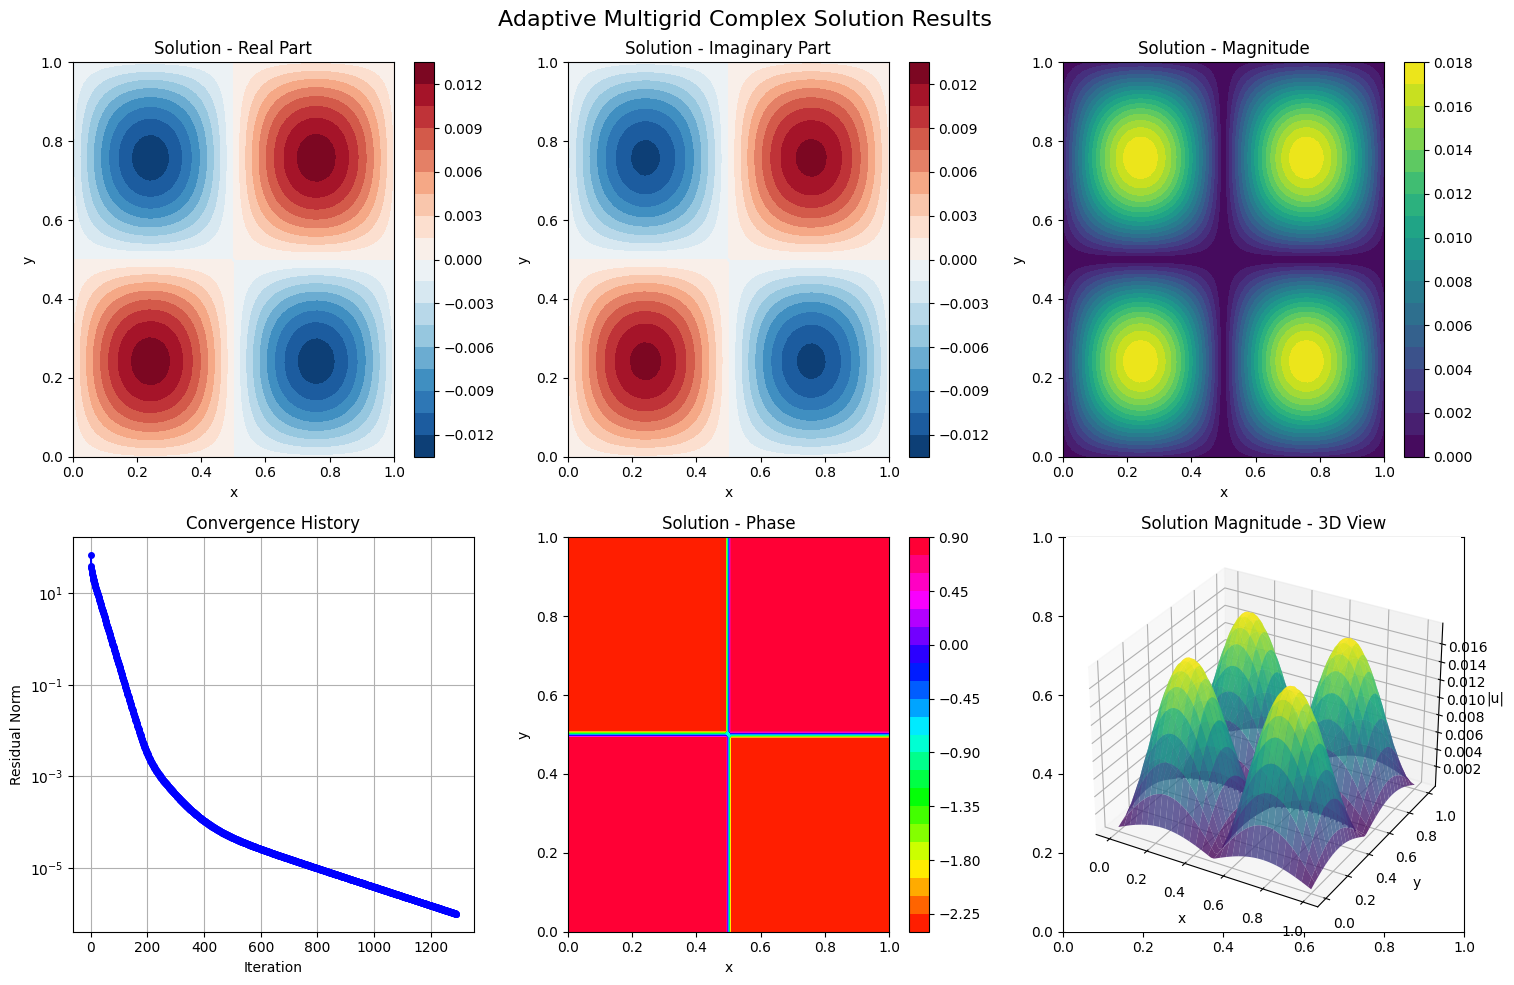

可视化完成!

性能统计:
网格大小: 64x64
未知数个数: 4096
收敛迭代次数: 1289
最终残差: 9.97e-07

测试案例 2: 修正复数问题 (指数右端项)
开始自适应多重网格复数求解
构建网格层次结构:
  Level 0: 64x64
  Level 1: 32x32
  Level 2: 16x16
  Level 3: 8x8
总共 4 层网格

构建各层系统矩阵:
Level 0:
创建 64x64 复数系数矩阵...
  系数: α = 2.0, β = 0.5j
  矩阵创建完成: (4096, 4096), 非零元素: 20224
Level 1:
创建 32x32 复数系数矩阵...
  系数: α = 2.0, β = 0.5j
  矩阵创建完成: (1024, 1024), 非零元素: 4992
Level 2:
创建 16x16 复数系数矩阵...
  系数: α = 2.0, β = 0.5j
  矩阵创建完成: (256, 256), 非零元素: 1216
Level 3:
创建 8x8 复数系数矩阵...
  系数: α = 2.0, β = 0.5j
  矩阵创建完成: (64, 64), 非零元素: 288

开始多重网格迭代:
----------------------------------------

迭代 1:
  V-循环 level 0, 网格大小: 64x64
    前光滑...
    残差范数: 1.11e+02
  V-循环 level 1, 网格大小: 32x32
    前光滑...
    残差范数: 5.35e+01
  V-循环 level 2, 网格大小: 16x16
    前光滑...
    残差范数: 2.48e+01
  V-循环 level 3, 网格大小: 8x8
    最粗网格直接求解...
    后光滑...
    后光滑...
    后光滑...
  迭代 1 完成，残差范数: 4.04e+02

迭代 2:
  V-循环 level 0, 网格大小: 64x64
    前光滑...
    残差范数: 2.82e+02
  V-循环 level 1, 网格大小: 32x32
    前光滑...
    残差范数: 8.08e+01
  V-

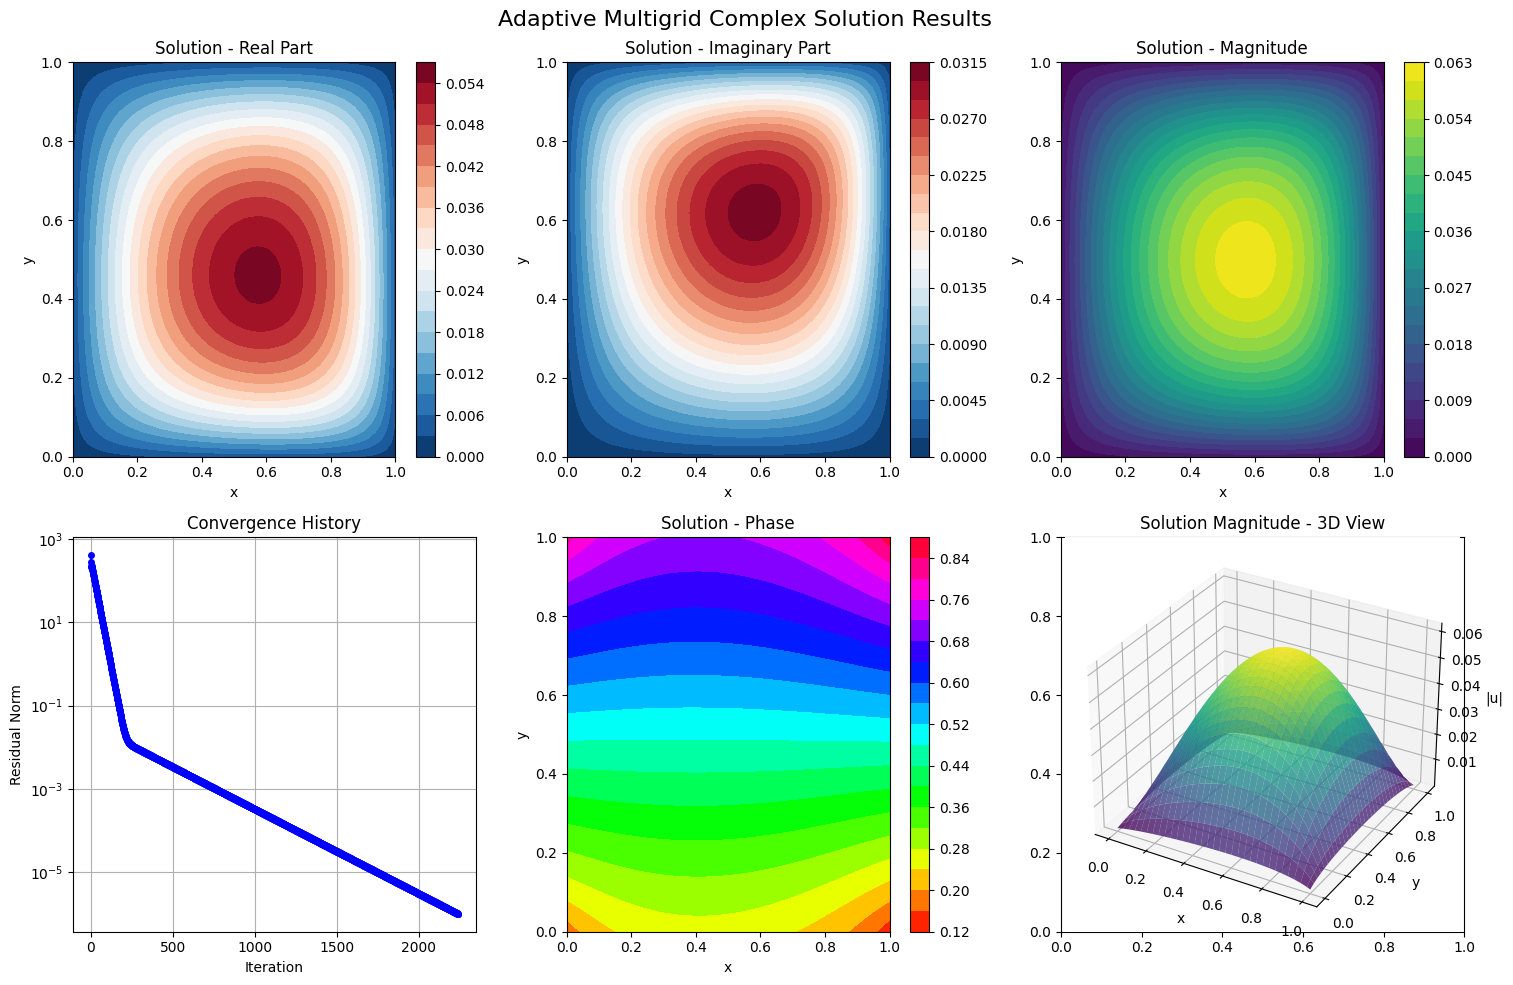

可视化完成!

性能统计:
网格大小: 64x64
未知数个数: 4096
收敛迭代次数: 2237
最终残差: 1.00e-06

所有测试完成!


In [2]:
# 主程序
if __name__ == "__main__":
    print("自适应多重网格复数求解器演示")
    print("=" * 50)
    
    # 创建求解器实例
    n = 64  # 网格大小
    solver = AdaptiveMultigridComplex(n=n, max_levels=4, tolerance=1e-6, max_iterations=10000)
    
    # 测试不同的问题参数
    test_cases = [
        {"alpha": 1.0, "beta": 1.0j, "func_type": "sine", "name": "复数椭圆问题 (正弦右端项)"},
        {"alpha": 2.0, "beta": 0.5j, "func_type": "exponential", "name": "修正复数问题 (指数右端项)"}
    ]
    
    for i, case in enumerate(test_cases):
        print(f"\n{'='*80}")
        print(f"测试案例 {i+1}: {case['name']}")
        print(f"{'='*80}")
        
        # 求解
        solution = solver.solve(alpha=case["alpha"], beta=case["beta"], func_type=case["func_type"])
        
        # 验证
        residual_norm, relative_error = solver.verify_solution(
            solution, alpha=case["alpha"], beta=case["beta"], func_type=case["func_type"]
        )
        
        # 可视化
        solver.plot_results(solution)
        
        # 性能统计
        print(f"\n性能统计:")
        print(f"网格大小: {n}x{n}")
        print(f"未知数个数: {n**2}")
        print(f"收敛迭代次数: {len(solver.convergence_history)}")
        print(f"最终残差: {solver.convergence_history[-1]:.2e}")
        
        # 重置收敛历史
        solver.convergence_history = []
    
    print(f"\n{'='*80}")
    print("所有测试完成!")
    print(f"{'='*80}")